## Reproduction of RQ2-3 (Figure 4, Table 6)

This notebook reproduces the values in Table 6 and Figure 4 (selection and ranking results presented in RQ2-3). 

In [19]:
import sys
sys.path.append("../../scripts/")
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_curve, auc
from evaluate_util import *

run = "repro"
RANKING_RESULT_PATH_D4J = f'/vol/fob-vol7/mi21/kunzmart/Master-Thesis/libro/results/ranking_features_d4j.csv'
GEN_TEST_PATH = f'../../data/Defects4J/gen_tests_paper/'
#RANKING_RESULT_PATH_D4J = f'../../results/ranking_features_d4j.csv'
#GEN_TEST_PATH = f'../data/Defects4J/gen_tests/'

with open(RANKING_RESULT_PATH_D4J) as f:
    rank_feature_df = pd.read_csv(f)

### Figure 4: selection accuracy for different thresholds

In [20]:
thresholds = range(0, 43)
max_df = rank_feature_df.groupby('bug_id').max()

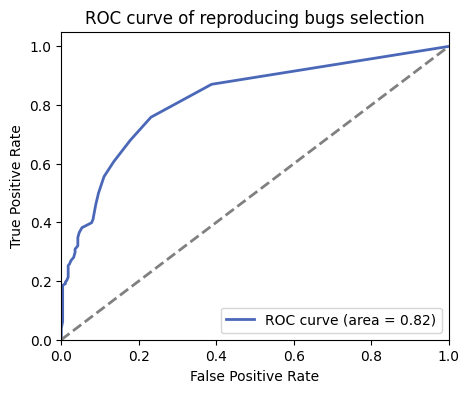

In [21]:
# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(max_df.success.tolist(), list(map(lambda x: x/50, max_df.clus_size_output_fib.tolist())))
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(5,4))
lw = 2
plt.plot(
    fpr,
    tpr,
    color='#4B68B8',
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="grey", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve of reproducing bugs selection")
plt.legend(loc="lower right")
plt.show()

In [22]:
import pandas as pd
import os

# Wähle eines der Experimente, das fehlgeschlagen ist
test_file_path = f'../../../results/{run}_bereinigt_ranking_features_d4j.csv'

print(f"--- DIAGNOSE FÜR: {test_file_path} ---\n")

if os.path.exists(test_file_path):
    # 1. Die ersten 3 Zeilen als rohen Text anzeigen (um Trennzeichen zu prüfen)
    print("1. ROHDATEN (Erste 3 Zeilen):")
    with open(test_file_path, 'r', encoding='utf-8', errors='replace') as f:
        for i in range(3):
            print(repr(f.readline()))
    
    print("\n" + "-"*30 + "\n")

    # 2. Pandas Laden mit automatischer Erkennung
    print("2. PANDAS DATAFRAME (Erste 3 Zeilen):")
    try:
        # engine='python' ist flexibler bei Trennzeichen
        df = pd.read_csv(test_file_path, sep=None, engine='python') 
        print(df.head(3))
        
        print("\n3. ALLE SPALTENNAMEN:")
        print(df.columns.tolist())
        
        # Check auf success
        if 'success' in df.columns:
            print("\n✅ Spalte 'success' GEFUNDEN.")
        else:
            print("\n❌ Spalte 'success' NICHT GEFUNDEN.")
            
    except Exception as e:
        print(f"Fehler beim Laden: {e}")

else:
    print("Datei existiert nicht am angegebenen Pfad.")

--- DIAGNOSE FÜR: ../../../results/repro_bereinigt_ranking_features_d4j.csv ---

1. ROHDATEN (Erste 3 Zeilen):
'bug_id,test_path,success,test_length,clus_size_output_fib,num_fib_tests,is_crash,actual_crash,actual_value_match,exception_type_match,test_exception_type_match\n'
'Time_8,Time_8_n3.txt,True,31,2,1,False,True,False,False,False\n'
'Time_8,Time_8_n1.txt,True,33,2,1,False,True,False,False,False\n'

------------------------------

2. PANDAS DATAFRAME (Erste 3 Zeilen):
   bug_id      test_path  success  test_length  clus_size_output_fib  \
0  Time_8  Time_8_n3.txt     True           31                     2   
1  Time_8  Time_8_n1.txt     True           33                     2   
2  Time_8  Time_8_n0.txt    False           33                     1   

   num_fib_tests  is_crash  actual_crash  actual_value_match  \
0              1     False          True               False   
1              1     False          True               False   
2              1     False         False 

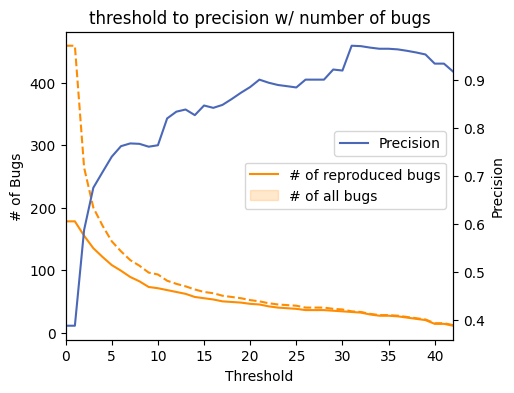

In [23]:
rows = []

for th in thresholds:
    selected_df = max_df[max_df.clus_size_output_fib >= th].reset_index()
    n = len(selected_df)
    if n == 0:
        precision = float('nan')   # oder continue, je nachdem, was du willst
    else:
        precision = selected_df.success.sum() / n
    rows.append({
        'threshold': th,
        'precision': precision,
        'num_bugs': n,
        'num_success_bugs': int(selected_df.success.sum())
    })

stat_df = pd.DataFrame(rows)
fig, ax1 = plt.subplots(figsize=(5,4))
ax2 = ax1.twinx()
p1 = sns.lineplot(data=stat_df['num_success_bugs'], color='darkorange', ax=ax1, legend='brief')
p1 = sns.lineplot(data=stat_df['num_bugs'], color='darkorange', ax=ax1, linestyle='--', legend='brief')
p2 = sns.lineplot(data=stat_df['precision'], color='#4B68B8', ax=ax2, legend='brief')

ax1.set_xlabel('Threshold')
ax1.set_ylabel('# of Bugs')
ax2.set_ylabel('Precision')
# p1.set_title("Threshold to Number of Has-BRT Bugs and Precision")
ax1.set_xlim(0,42)
ax2.set_xlim(0,42)
ax1.set_title('threshold to precision w/ number of bugs')
# ax1.legend(['# of reproduced bugs', '# of all bugs'], loc='upper left', bbox_to_anchor=(1.1, 0.9))
ax1.legend(['# of reproduced bugs', '# of all bugs'], loc='center right')
ax2.legend(['Precision'], loc= 'upper right', bbox_to_anchor=(1.0, 0.7))

plt.show()

In [24]:
THR = 1
df = max_df[max_df.clus_size_output_fib <= THR]
selected_df = max_df[max_df.clus_size_output_fib > THR].reset_index()

print(f'[Threshold = {THR}]')
print("# precision: ", len(selected_df[selected_df.success]) / len(selected_df))
print("# recall: ", len(selected_df[selected_df.success]) / (len(selected_df[selected_df.success]) + len(df[df.success])))
print("# accuracy: ", (len(selected_df[selected_df.success]) + len(df[~df.success]))/ (len(max_df)))
print("Reduction rate: ", len(max_df), '=>', len(selected_df), ', ', str(round(len(selected_df)/len(max_df)*100, 2)) + '%')

[Threshold = 1]
# precision:  0.5871212121212122
# recall:  0.8707865168539326
# accuracy:  0.7124183006535948
Reduction rate:  459 => 264 ,  57.52%


### Table 6: ranking result on selected data 
* max_output_clus_size threshold=1

#### Defects4J Ranking Result

In [25]:
run = "repro"
with open(f'../../../results/{run}_cleaned_ranking_d4j_selected_th1.csv') as f:
#with open(f'../../results/ranking_d4j_selected_th1.csv') as f:
    rank_df = pd.read_csv(f)

evaluate_ranking(rank_df)

{'wef@1_sum': 156,
 'wef@1_mean': 0.609375,
 'acc@1': 100,
 'wef@3_sum': 381,
 'wef@3_mean': 1.48828125,
 'acc@3': 137,
 'wef@5_sum': 522,
 'wef@5_mean': 2.0390625,
 'acc@5': 145}

Aggregated result from random baseline (100 runs)

In [26]:
with open('../../results/ranking_random_baseline_d4j.json') as f:
    baseline_result = json.load(f)

mean = lambda l: sum(l)/len(l)

for N in [1, 3, 5]:
    wasted_effort_results = baseline_result[str(N)]['wefs']
    acc_results = baseline_result[str(N)]['acc']
    sum_result = mean([v[0] for v in wasted_effort_results])
    mean_result = mean([v[1] for v in wasted_effort_results])
    print('wef_sum@{}'.format(N), round(sum_result, 2))
    print('wef_mean@{}'.format(N), round(mean_result, 2))
    print('acc@{} : {}'.format(N, mean(acc_results)))

wef_sum@1 233.77
wef_mean@1 0.67
acc@1 : 116.23
wef_sum@3 599.37
wef_mean@3 1.71
acc@3 : 172.4
wef_sum@5 874.48
wef_mean@5 2.5
acc@5 : 191.99
